In [1]:
# import Serial libraries
import serial
import serial.tools.list_ports
import time
import numpy as np
import matplotlib.pyplot as plt
from cartpole_lib_python import *

In [2]:
# list serial ports
ports = list(serial.tools.list_ports.comports())
for p in ports:
    print(p) 

/dev/cu.Bluetooth-Incoming-Port - n/a
/dev/cu.usbmodem101 - Feather ESP32-S2


In [25]:
start = time.time()

sp = cartpole_open_serial("/dev/cu.usbmodem101")
data = cartpole_safe_read(sp)
cartpole_close_serial(sp)

end = time.time()

print("time elapsed", end-start, "seconds")
data

time elapsed 0.02965712547302246 seconds


['25.223', '0.000', '1.552', '0.000', '2.084', '0.000', '0.000', '0.000']

In [21]:
control_frequency = 100 # Hz
control_period = 1/control_frequency
T = 5    # seconds
N = int(T*control_frequency) # number of control steps

states = np.zeros((N,4)) # initialize data array
controls = np.zeros((N,1)) # initialize control array
control_input = np.zeros((N,2)) # just for latency testing/debugging 
loop_time = []

elapsed_count = 0

k_matrix = np.array([-2.9582, -4980.7, -56.984, -45180.2])
k_multiplier = 0.001
control_clamp = 1.5
mid_point = 0.25

sp = cartpole_open_serial("/dev/cu.usbmodem101")
cartpole_busy_sleep(1, loop_start = time.time())

for i in range(N):
    # read the encoder data
    # save the encoder data
    # write a 0 torque command
    # wait for the next control period

    time_start = time.time()

    encoder_data = cartpole_safe_read(sp)
    states[i,0] = -1 * (encoder_data[0] * 0.01) - 0.35 # x pos
    states[i,1] = (encoder_data[2] % (2*np.pi)) - (np.pi/2) # theta
    states[i,2] = -1 * (encoder_data[1] * 0.01) # x vel
    states[i,3] = encoder_data[3] # theta vel 

    state = np.matrix([[states[i,0]], [states[i,1]], [states[i,2]], [states[i,3]]])

    control_input[i,0] = encoder_data[6]
    control_input[i,1] = encoder_data[7]

    control = k_multiplier*np.matmul(k_matrix,state)
    control = control.item(0)

    # clamp control to be between -1 and 1
    if control > control_clamp:
        control = control_clamp
    elif control < -control_clamp:
        control = -control_clamp

    controls[i] = control
    
    cartpole_write_motors(sp,control,0)

    elapsed_count += 1
    loop_time.append(time.time() - time_start)
    cartpole_busy_sleep(control_period, loop_start = time_start)

cartpole_write_motors(sp,0,0)
cartpole_close_serial(sp)

In [13]:
cartpole_close_serial(sp)

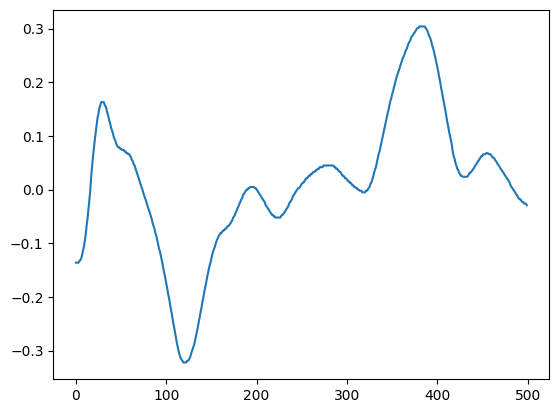

In [ ]:
plt.plot(error_array, label = "error")

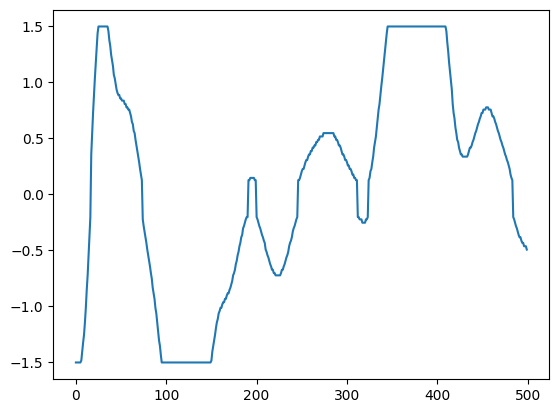

In [ ]:
plt.plot(control_array, label = "control")

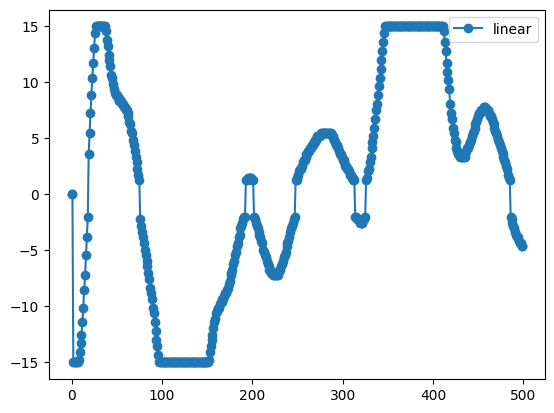

In [ ]:
# plot the data
# plt.plot(data[:,0], label = "linear")
# plt.plot(data[:,1], label = "shoulder")
# plt.plot(data[:,2], label = "elbow")
plt.plot(control_input[:,0] * 10, label = "linear", marker = "o") 
plt.legend()

plt.show()

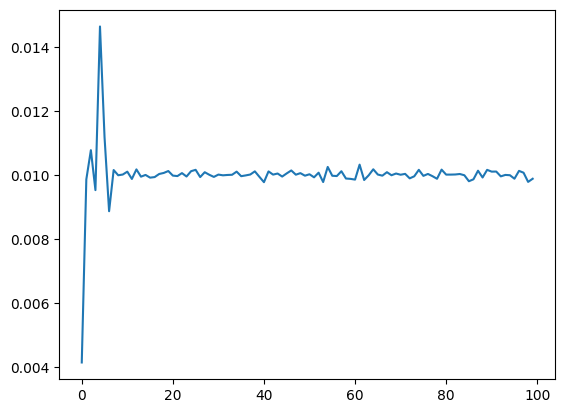

In [23]:
loop_time = np.array(loop_time)
plt.plot(loop_time)